# Project 2 Part 5

**Objectives**

1. Preprocessing
    - Load and describe aspects of the dataset.
    - Create new column labeling reviews as high or low ratings.
    - Use NLTK and SpaCy for basic preprocessing, saving variations as new columns.
    - Save processed data as a joblib file in Data-NLP
2. EDA and Visualization
    - Create word clouds of frequent and significant words in each group.
    - Using FreqDist, compare frequency distribution across the groups.
    - Perform n-gram analysis of groups.
    - Perform sentiment analysis of groups.
3. Evaluation and Reporting
    - Describe aspects of high and low rated movies.
    - Update the Project README to include visuals, credits, recommendations.

### Imports, loading, functions

In [126]:
# Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

pd.set_option('display.max_colwidth', 300)

In [128]:
# nltk.download('vader_lexicon')

In [2]:
# Custom functions
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()

    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).

    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm

    if nlp is None:
        nlp = spacy.load("en_core_web_sm")

    processed_texts = []

    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue

            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue

            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())

        processed_texts.append(tokens)
    return processed_texts

In [51]:
# Define a custom function for plotting the Real and Fake WordClouds
def plot_wordclouds(high_cloud, low_cloud, title='Comparing Word Usage'):
    """Plots the wordlcouds for our two groups"""
    ## Plot the Images
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    axes[0].imshow(high_cloud)
    axes[0].set_title('High Reviews')
    axes[0].axis('off')
    
    axes[1].imshow(low_cloud)
    axes[1].set_title('Low Reviews')
    axes[1].axis('off')
    fig.tight_layout()
    
    fig.suptitle(title,y=1.0, fontsize='xx-large');
    return fig

### 1. Preprocessing

#### Load and inspect data

In [11]:
# Load data
df = pd.read_csv("Data-NLP/movie_reviews_v2.csv")
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The ...",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a ...",6.0


In [12]:
# Check for duplicates
df.duplicated().sum()

0

In [13]:
# Check for missing values
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

- Our target is predicting ratings, so rows without a rating will have no use.

In [14]:
# Drop rows with missing ratings
df = df.dropna(subset=['rating'])
df.isna().sum()

review_id         0
movie_id          0
imdb_id           0
original_title    0
review            0
rating            0
dtype: int64

#### Add new rating target column

- Create a new column labeling the movie as either High-rating (>=9) or Low-rating (<=4). Middle ratings will be excluded from analysis.

In [16]:
# Create a simple sorting function
def create_rating(x):
    if x>=9.0:
        return "high"
    elif x <=4.0:
        return "low"
    else: 
        return None

In [21]:
# Use the function to create a new "highlow_rating" column with groups
df['highlow_rating'] = df['rating'].map(create_rating)
df['highlow_rating'].value_counts(dropna=False)

None    5035
low     1224
high    1195
Name: highlow_rating, dtype: int64

In [25]:
# Limit dataset to just high and low rated movies
df = df[df['highlow_rating'].isin(['low', 'high'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2419 entries, 1 to 8647
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       2419 non-null   object 
 1   movie_id        2419 non-null   int64  
 2   imdb_id         2419 non-null   object 
 3   original_title  2419 non-null   object 
 4   review          2419 non-null   object 
 5   rating          2419 non-null   float64
 6   highlow_rating  2419 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 151.2+ KB


#### Preprocess text with SpaCy and NLTK

In [34]:
# Create custom nlp object and disable named entity recognizer
nlp_light = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp_light.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

**Add new columns for tokenized, lemmatized data**

In [35]:
## Create new columns by removing stopwords and splitting strings
# Add column of tokenized text
df['tokenized'] = batch_preprocess_texts(df['review'], nlp=nlp_light)
# Add column of lemmatized text
df['lemmatized'] = batch_preprocess_texts(df['review'], nlp=nlp_light, use_lemmas=True)

# Add column of single strings containing all tokenized words
df['tokenized_joined'] = df['tokenized'].map(lambda x: " ".join(x))
# Add column of single strings containing all lemmatized words
df['lemmatized_joined'] = df['lemmatized'].map(lambda x: " ".join(x))

df.head(1)

2419it [00:27, 88.86it/s] 
2419it [00:27, 86.85it/s] 


,review_id,movie_id,imdb_id,original_title,review,rating,highlow_rating,tokenized,lemmatized,tokenized_joined,lemmatized_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation


In [36]:
# Save processed data as a joblib
import joblib
fpath=  "Data-NLP/reviews_processed.joblib"
joblib.dump(df, fpath, compress=9)

['Data-NLP/reviews_processed.joblib']

### 2. EDA and Vis

#### Create separate dataframes for EDA

In [39]:
# Get separate High/Low dataframes for EDA/visualizations
# High reviews
high_df = df[df['highlow_rating']=='high']
high_df.head(1)

,review_id,movie_id,imdb_id,original_title,review,rating,highlow_rating,tokenized,lemmatized,tokenized_joined,lemmatized_joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0,high,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, great, escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love great escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation


In [40]:
# Get separate High/Low dataframes for EDA/visualizations
# Low reviews
low_df = df[df['highlow_rating']=='low']
low_df.head(1)

,review_id,movie_id,imdb_id,original_title,review,rating,highlow_rating,tokenized,lemmatized,tokenized_joined,lemmatized_joined
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",3.0,low,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, poin...","[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, enc...",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know abl...,underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation f...


#### Create WordClouds of High and Low reviews

In [52]:
# Get a list of all lemmatized text in all articles
high_rev_list = " ".join(high_df['lemmatized_joined'])
low_rev_list = " ".join(low_df['lemmatized_joined'])

In [53]:
# Generate the WordCloud images
wordcloud_kws = dict(min_word_length=2, width=800, height=600, random_state=42)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_rev_list)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(low_rev_list)

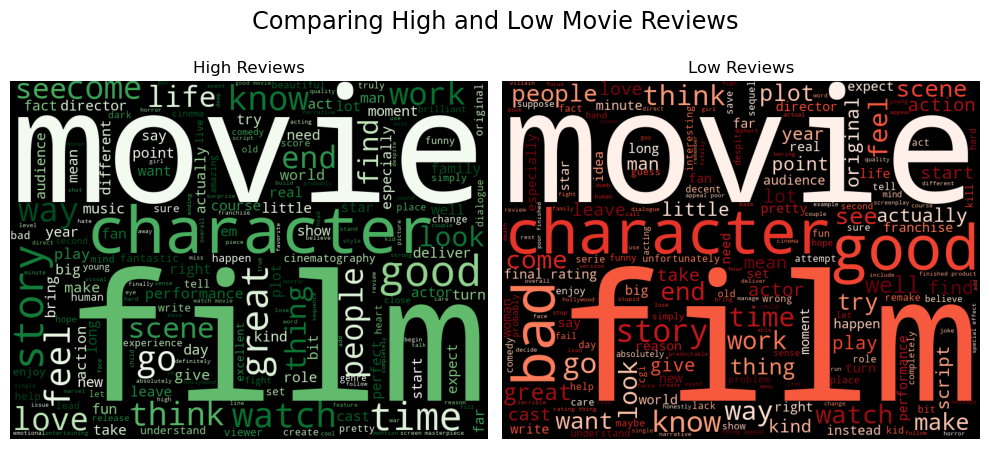

In [54]:
# Display the figure
fig = plot_wordclouds(high_cloud, low_cloud, title='Comparing High and Low Movie Reviews')
# Saving a copy for README
#fig.savefig('images/wordclouds-real-fake.png', dpi=300, bbox_inches='tight', transparent=False)

In [105]:
# Add more custom stopwords for EDA
custom_stopwords = [*STOPWORDS,'movie', 'film', 'like', 'good', 'character', 'story', 'watch', 'go', '★']

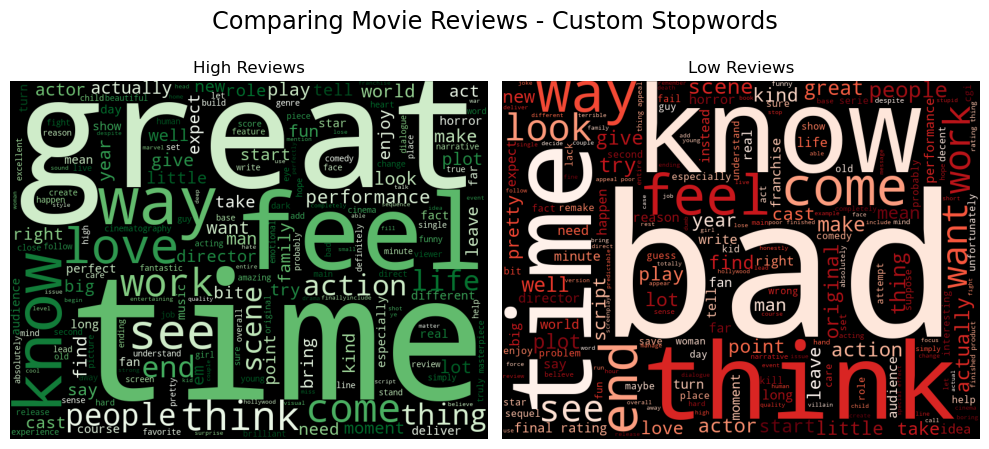

In [57]:
## Generate the WordCloud Images using the custom stopwords
wordcloud_kws = dict(min_word_length=2,width=800, height=600, random_state=42,
                     stopwords=custom_stopwords)
high_cloud = WordCloud(**wordcloud_kws, colormap='Greens').generate(high_rev_list)
low_cloud = WordCloud(**wordcloud_kws, colormap='Reds').generate(low_rev_list)

# Plot the Images
fig =  plot_wordclouds(high_cloud,low_cloud, title="Comparing Movie Reviews - Custom Stopwords")

# Save figure
fig.savefig('Images/movie_reviews_wordcloud.png', dpi=300,transparent=False, bbox_inches='tight')

#### Create Frequency Distribution plots for High and Low reviews

**Frequency of Tokens in Original Reviews**

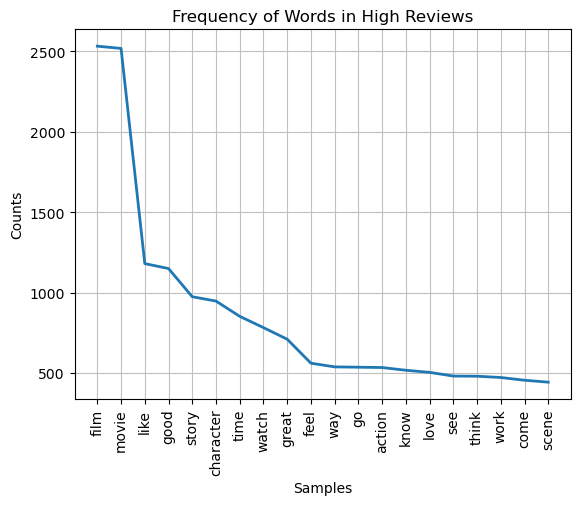

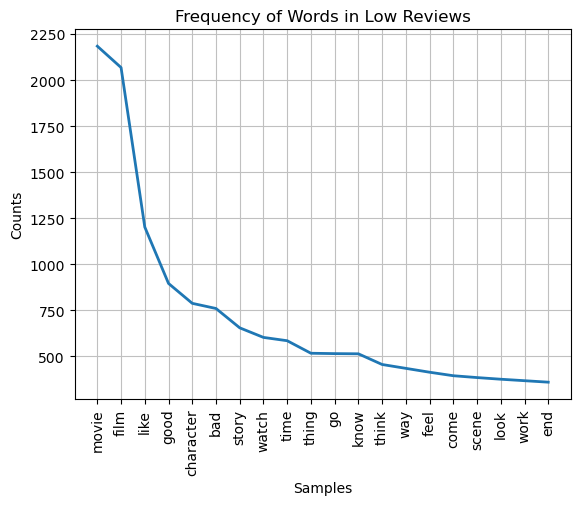

In [58]:
## Get frequency of tokens
# Create list of all tokens in all documents
high_lemmas = high_df['lemmatized'].explode().to_list()
low_lemmas = low_df['lemmatized'].explode().to_list()

# Get frequencies
high_freq_dist = FreqDist(high_lemmas)
low_freq_dist = FreqDist(low_lemmas)

# Plot frequencies
high_freq_dist.plot(20, title='Frequency of Words in High Reviews')
low_freq_dist.plot(20, title='Frequency of Words in Low Reviews');

- Remove custom stopwords and plot Frequency Distribution plots again.

In [114]:
# Add more custom stopwords for EDA
custom_stopwords = [*STOPWORDS,'movie', 'film', 'like', 'good', 'character', 'story', 'watch', 'go', '★']

In [115]:
# Remove Stopwords
def remove_stopwords(tokens):
    no_stops = []
    for token in tokens:
        if token in custom_stopwords:
            continue
        else:
            no_stops.append(token)
    return no_stops

In [116]:
# Add new columns for FreqDist with custom stopwords
high_df['lemmatized_cs'] = high_df['lemmatized'].map(remove_stopwords)
low_df['lemmatized_cs'] = low_df['lemmatized'].map(remove_stopwords)

C:\Users\Malue\AppData\Local\Temp\ipykernel_13068\344121310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df['lemmatized_cs'] = high_df['lemmatized'].map(remove_stopwords)
C:\Users\Malue\AppData\Local\Temp\ipykernel_13068\344121310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df['lemmatized_cs'] = low_df['lemmatized'].map(remove_stopwords)


In [117]:
## Get frequency of tokens
# Create list of all tokens in all documents
high_lemmas = high_df['lemmatized_cs'].explode().to_list()
low_lemmas = low_df['lemmatized_cs'].explode().to_list()

# Get frequencies
high_freq_dist = FreqDist(high_lemmas)
low_freq_dist = FreqDist(low_lemmas)

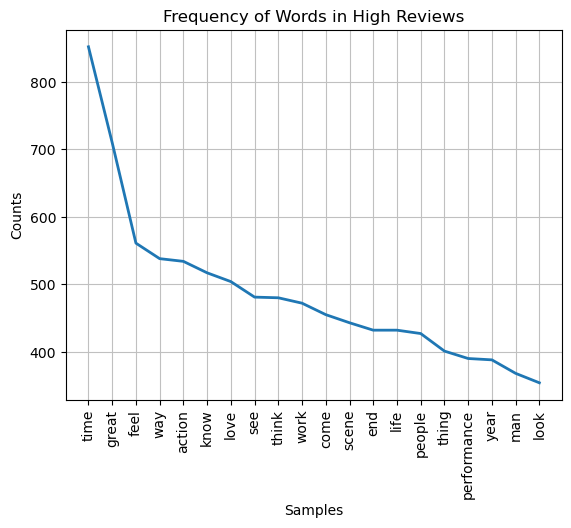

In [118]:
# Plot and frequencies
high_freq_dist.plot(20, title='Frequency of Words in High Reviews', show=False)
plt.savefig('Images/high_review_freq_plot.png')

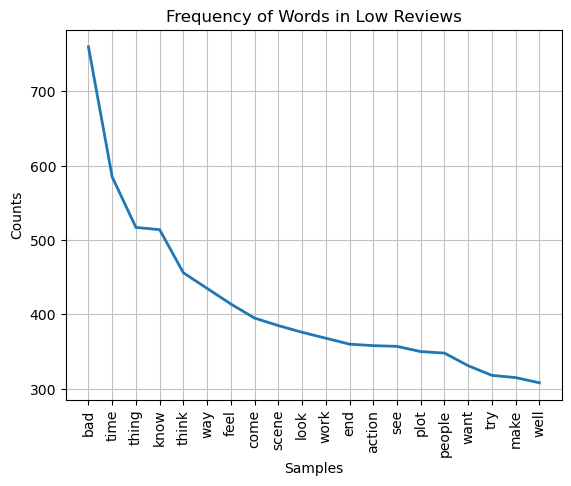

In [119]:
# Plot and frequencies
low_freq_dist.plot(20, title='Frequency of Words in Low Reviews', show=False)
plt.savefig('Images/low_review_freq_plot.png')

- We can now see some of the differences between the list of tokens for High and Low Reviews.

#### Perform n-gram analysis for High and Low reviews

**Calculate Frequency Score of n-grams**

In [120]:
#Instantiate a measures object for Bigrams
measures = BigramAssocMeasures()

In [121]:
# Create measure class
measures = BigramAssocMeasures()

# Create collector classes
bg_high_finder = BigramCollocationFinder.from_words(high_lemmas)
bg_low_finder = BigramCollocationFinder.from_words(low_lemmas)

In [122]:
#Set a minimum frequency
min_frequency = 3  
#Use bigram finder to find bigrams in reviews
bg_high_finder.apply_freq_filter(min_frequency)
bg_low_finder.apply_freq_filter(min_frequency)

In [123]:
# Calculate high-rating ngram scores and save as df
high_ngram_scores = bg_high_finder.score_ngrams(measures.raw_freq)
high_ngram_scores_df = pd.DataFrame(high_ngram_scores, columns=['High Review N-grams', 'High Review Freq'])

## Calculate low-rating ngram scores and save as df
low_ngram_scores = bg_low_finder.score_ngrams(measures.raw_freq)
low_ngram_scores_df = pd.DataFrame(low_ngram_scores, columns=['Low Review N-grams', 'Low Review Freq'])

## Display the frequency scores
display(high_ngram_scores_df.head(20),low_ngram_scores_df.head(20))

,High Review N-grams,High Review Freq
0,"(comic, book)",0.000537
1,"(special, effect)",0.000459
2,"(sci, fi)",0.000389
3,"(star, wars)",0.000389
4,"(long, time)",0.000342
5,"(john, wick)",0.000335
6,"(real, life)",0.000335
7,"(<, >)",0.000319
8,"(action, sequence)",0.000311
9,"(spider, man)",0.000296


,Low Review N-grams,Low Review Freq
0,"(final, rating)",0.001234
1,"(finished, product)",0.000926
2,"(appeal, poor)",0.000916
3,"(poor, finished)",0.000916
4,"(rating, thing)",0.000916
5,"(thing, appeal)",0.000916
6,"(special, effect)",0.000704
7,"(avoid, possible)",0.000559
8,"(boring, disappointing)",0.000559
9,"(disappointing, avoid)",0.000559


- The bi-grams for movies with positive reviews seem to make a lot of references to the content and characters, while movies with bad reviews have more mentions of production and other factors. It seems people who are fans of a particular series or character might be more forgiving, or are not as harsh in their assessment of media portraying them.

In [124]:
df_ngrams = pd.concat([high_ngram_scores_df, low_ngram_scores_df], axis=1)
df_ngrams.head()

,High Review N-grams,High Review Freq,Low Review N-grams,Low Review Freq
0,"(comic, book)",0.000537,"(final, rating)",0.001234
1,"(special, effect)",0.000459,"(finished, product)",0.000926
2,"(sci, fi)",0.000389,"(appeal, poor)",0.000916
3,"(star, wars)",0.000389,"(poor, finished)",0.000916
4,"(long, time)",0.000342,"(rating, thing)",0.000916


In [125]:
# Generate string table to insert in markdown cell
movie_review_bigrams = df_ngrams.head(10).to_markdown(index=False)
print(movie_review_bigrams)

| High Review N-grams    |   High Review Freq | Low Review N-grams          |   Low Review Freq |
|:-----------------------|-------------------:|:----------------------------|------------------:|
| ('comic', 'book')      |        0.000537023 | ('final', 'rating')         |       0.00123433  |
| ('special', 'effect')  |        0.000459194 | ('finished', 'product')     |       0.000925747 |
| ('sci', 'fi')          |        0.000389147 | ('appeal', 'poor')          |       0.000916104 |
| ('star', 'wars')       |        0.000389147 | ('poor', 'finished')        |       0.000916104 |
| ('long', 'time')       |        0.00034245  | ('rating', 'thing')         |       0.000916104 |
| ('john', 'wick')       |        0.000334667 | ('thing', 'appeal')         |       0.000916104 |
| ('real', 'life')       |        0.000334667 | ('special', 'effect')       |       0.000703954 |
| ('<', '>')             |        0.000319101 | ('avoid', 'possible')       |       0.000559306 |
| ('action', 'sequen

#### Sentiment Analysis

**Perform sentiment analysis using VADER's lexicon**

In [150]:
# Instantiate SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [154]:
# Dataframe for High Review movies
sa_high = pd.DataFrame(high_df[['review', 'highlow_rating']])
sa_high['sentiment_scores'] = high_df['review'].map(sia.polarity_scores)
sa_high_scores = sa_high['sentiment_scores'].apply(pd.Series)
sa_high_df = pd.concat([sa_high, sa_high_scores], axis=1).drop('sentiment_scores', axis=1)
sa_high_df.head(3)

,review,highlow_rating,neg,neu,pos,compound
1,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",high,0.053,0.587,0.360,0.9450
15,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ag...",high,0.030,0.710,0.260,0.9942
21,"All you people are so scared of me. Most days I'd take that as a compliment. But it ain't me you gotta worry about now.\r\n\r\nPitch Black is directed by David Twohy and collectively written by Twohy and Ken and Jim Wheat. It stars Vin Diesel, Radha Mitchell, Cole Hauser, Keith David, Lewis Fitz...",high,0.076,0.802,0.121,0.9859


In [155]:
# Dataframe for Low Review movies
sa_low = pd.DataFrame(low_df[['review', 'highlow_rating']])
sa_low['sentiment_scores'] = low_df['review'].map(sia.polarity_scores)
sa_low_scores = sa_low['sentiment_scores'].apply(pd.Series)
sa_low_df = pd.concat([sa_low, sa_low_scores], axis=1).drop('sentiment_scores', axis=1)
sa_low_df.head(3)

,review,highlow_rating,neg,neu,pos,compound
6,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predom...",low,0.186,0.704,0.110,-0.8724
7,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds....,low,0.135,0.773,0.093,-0.5267
20,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up...",low,0.221,0.655,0.125,-0.9934


**Check for sentiment mismatch based on review scores**

In [159]:
## Create a filter for positive and negative sentiment in opposite dataframe
# Positive sentiment in low-rated movies
pos_sent_reviews = sa_low_df['compound'] > 0
pos_sent_reviews.sum()

578

In [163]:
sa_low_df.shape

(1224, 6)

In [162]:
# Negative sentiment in high-rated movies
neg_sent_reviews = sa_high_df['compound'] < 0
neg_sent_reviews.sum()

130

In [164]:
sa_high_df.shape

(1195, 6)

- While only 130 of 1195 highly-rated movies had negative sentiment, 578 of 1224 low-rated movies had positive sentiment. It seems using VADER is more likely to give up false-positive-sentiment than it is false-negative.
- Let's examine a couple and try to see what the issue could be.

In [166]:
# Search for 'positive' reviews in the low-rated movies
pos_sent_low_rating = sa_low_df.loc[pos_sent_reviews, ['review', 'highlow_rating', 'compound']]
pos_sent_low_rating.head(5)

,review,highlow_rating,compound
72,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like so...",low,0.8695
111,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to two direct-to-video sequels that I'm really not t...",low,0.6523
125,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short clothes, and bouncing around sensually in an atmosp...",low,0.9967
132,"After writing three high-praise reviews, I tried to think of the worst movie that I'd ever sat through and this movie came to mind, front and center. I've sat through plenty of ""chick flicks"" but even by chick flick standards this one is just horrible. (to give this a more modern reference, I ra...",low,0.9408
148,"I remember loving this film as a kid. Rewatching the film as an adult, the film does not hold up. I really remember the third act of the film before rewatching the film and it is going to be the only thing I will remember about the film. There are two fun scenes in my opinion: the ending and Cru...",low,0.7845


In [167]:
# Search for 'negative' reviews in the high-rated movies
neg_sent_high_rating = sa_high_df.loc[neg_sent_reviews, ['review', 'highlow_rating', 'compound']]
neg_sent_high_rating.head(5)

,review,highlow_rating,compound
22,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",high,-0.3391
59,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",high,-0.5574
75,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows fo...",high,-0.7907
117,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on...",high,-0.9920
254,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson,...",high,-0.9755


- It seems the movies with low ratings but apparent positive sentiment included words or terms such as 'great cast' or 'attractive' when describing the actors, although the movies weren't good. People mention 'loving the movie' as a kid but not when rewatchingg as an adult, or writing other 'high-praise reviews', just for other movies.
- Likewise the movies with high rating but low sentiment scores describe subject matter that could lower the score, including mentions of 'fallible', 'doubt', 'simple', 'death sentence', 'ridiculous', or even "don't care for it". However, in context these comments contain praise, discussions of negative or troubling subjects and themes in the movie, or expressions saying it is underrated.

### 3. Evaluation and Reporting

**Based on the previous analysis, what should a film-maker do, or not do, to make a highly-rated movie?**

- **High-rated movies**
    - Movies with high ratings had comments centering on popular franchises, specific stories, and specific characters. Maybe audiences are more forgiving of mediocre movies if they feature beloved characters, or perhaps audiences find these movies truly entertaining to a high degree.
    - High rated movies are more likely to be action or science-fiction stories, with high production, quality soundtracks, and good visuals.
    - Reviews mention favorite directors, and gripping, enthralling stories.



- **Low-rated movies**
    - These movies had less comments about characters and franchises - the content - and more comments about the quality of the movie.
    - Low-rated movies suffered from low quality production, with movies that looked and felt unfinished. Visuals were weak, and the soundtracks were lacking.
    - Stories were more likely to be viewed as boring, predictable, and a waste of time. Audiences were unimpressed with attractive no-name actors in tales that did not engage or pull them in.